# Mann-Kendall test for time series.

In [201]:
import pandas as pd
import pymannkendall as mk

# Load data
df = pd.read_excel('dados-agricolas/ap.xlsx', index_col='data')

# Convert data to numbers (if they are in string format)
df = df.apply(pd.to_numeric)

# Create a list to store the results
results = []

# Iterate over the columns (county) and perform the Mann-Kendall test
for col in df.columns:
    series_data = df[col]
    
    # Execute Mann-Kendall test
    test_results = mk.original_test(series_data)
    
    # Store the results in to a list
    results.append({
        'County': col,
        'Trend': test_results.trend,
        'Test statistic': test_results.slope,
        'P-value': test_results.p
    })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Salve the results
df_results.to_excel('results_mannkendall_ap.xlsx', index=False)

# Sen's Slope test for time series

In [206]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_excel('dados-chirps-ana/ana/ana-precipitação.xlsx')

# Select only the columns with meteorological data(assuming that data columns are named as 'data' in the DataFrame)
dados_meteorologicos = df.drop('data', axis=1)  # remove data column

# Function to calculate Sen's Slope
def sens_slope(x):
    n = len(x)
    slopes = []
    for i in range(n):
        for j in range(i + 1, n):
            slope = (x[j] - x[i]) / (j - i)
            slopes.append(slope)
    return np.nanmedian(slopes)

# Calculate Sen's Slope for each county
slopes = {}
for coluna in dados_meteorologicos.columns:
    slope = sens_slope(dados_meteorologicos[coluna].values)
    slopes[coluna] = slope

# Creating Dataframe for the results
resultados = pd.DataFrame(slopes.items(), columns=['Município', "Sen's Slope"])

# Salve the results
resultados.to_excel('results_sens_slope_ap.xlsx', index=False)

In [209]:
import pandas as pd
import numpy as np
from scipy.stats import norm  # Import norm function for z-score calculation

# Load data
df = pd.read_excel('dados-agricolas/ap.xlsx')

# Select only the columns with meteorological data (assuming 'data' as the column name)
dados_meteorologicos = df.drop('data', axis=1)  # remove data column

# Function to calculate Sen's Slope, p-value, and confidence interval
def sens_slope(x):
    n = len(x)
    slopes = []
    for i in range(n):
        for j in range(i + 1, n):
            slope = (x[j] - x[i]) / (j - i)
            slopes.append(slope)
    median_slope = np.nanmedian(slopes)
    # Calculate p-value using Sen's method
    var_sen = (n * (n - 1) * (2 * n + 5)) / 18
    z = (median_slope - 0) / np.sqrt(var_sen)
    p_value = 2 * (1 - norm.cdf(abs(z)))  # assuming a two-tailed test
    # Calculate confidence interval (example for 95% confidence)
    se = np.sqrt(var_sen)
    margin_error = 1.96 * se  # for 95% CI
    lower_bound = median_slope - margin_error
    upper_bound = median_slope + margin_error
    return median_slope, p_value, lower_bound, upper_bound

# Calculate Sen's Slope, p-value, and confidence interval for each county
results = {}
for col in dados_meteorologicos.columns:
    slope, p_val, lower, upper = sens_slope(dados_meteorologicos[col].values)
    results[col] = {'Sen\'s Slope': slope, 'P-Value': p_val, 'Lower CI': lower, 'Upper CI': upper}

# Creating DataFrame for the results
result_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
result_df = result_df.rename(columns={'index': 'Município'})

# Save the results
result_df.to_excel('results_sens_slope_with_stats.xlsx', index=False)

# Visualization map for trend results
#### Obs: Ensure that county's name are equal in the worksheet and in the shapefile. If they're different the map will not show the correctly information.

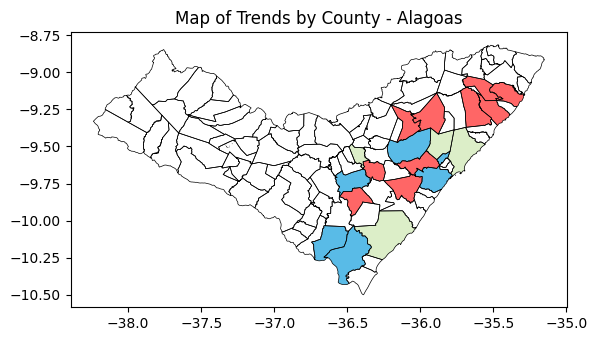

In [202]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the shapefile of Alagoas
alagoas = gpd.read_file('AL_Municipios_2022/AL_Municipios_2022.shp')

# Load data
dados = pd.read_excel('results_mannkendall_ap.xlsx')

# Merge shapefile data with spreadsheet data
merged_data = alagoas.merge(dados, how='left', left_on='NM_MUN', right_on='County')

# Map the new trends to corresponding colors
color_dict = {
    'no trend': '#DCEEC8',
    'increasing': '#59bbe7',
    'decreasing': '#FF6666'
}
merged_data['color'] = merged_data['Trend'].map(color_dict)

# Fill missing values (NaN) with a default color
merged_data['color'].fillna('white', inplace=True)

# Plot the map with separate borders and filling
fig, ax = plt.subplots(1, 1)

# Plot the filling of areas (colors)
merged_data.plot(ax=ax, color=merged_data['color'], legend=False)

# Plot the borders of each county separately
merged_data.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Add a title
plt.title('Map of Trends by County - Alagoas')

# Display the map
plt.show()

# Cut the map to the area of interest

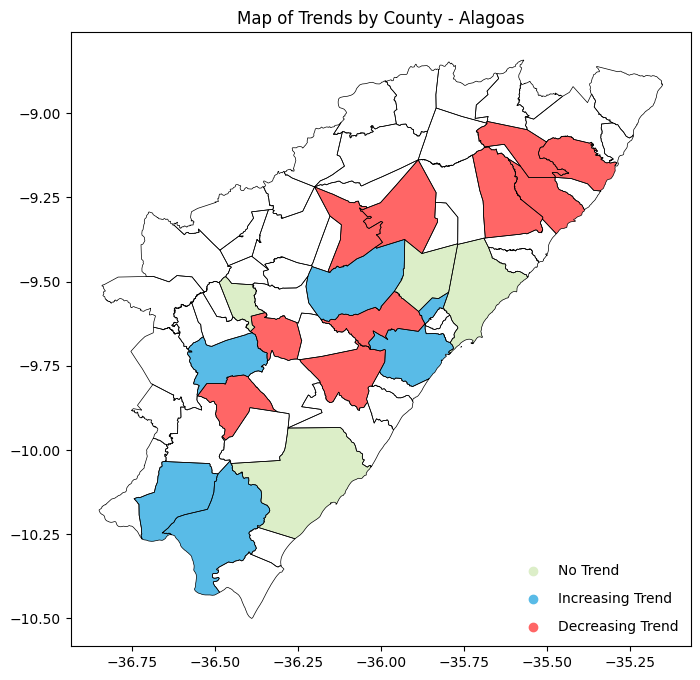

In [205]:
# Define limits to the interest area (bounding box)
minx, miny, maxx, maxy = -36.67, -10.61, -34, -9  # Example of coordinates

# Cut the interest area
clipped_data = merged_data.cx[minx:maxx, miny:maxy]

# Plot the map with separate borders and filling of the clipped area
fig, ax = plt.subplots(figsize=(8, 8))
clipped_data.plot(ax=ax, color=clipped_data['color'], legend=False)
clipped_data.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Add label
legend_labels = {
    'no trend': 'No Trend',
    'increasing': 'Increasing Trend',
    'decreasing': 'Decreasing Trend'
}

for key, value in legend_labels.items():
    ax.scatter([], [], color=color_dict[key], label=value)

ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower right')

# Add Title
plt.title('Map of Trends by County - Alagoas')

# Show map
plt.show()